In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [3]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [4]:
df_raw.groupby("Rating").size()

Rating
1     97
2     34
3    101
4     91
5    176
dtype: int64

#### Prepare X and Y

In [5]:
RANDOM_STATE = 42
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [6]:
df = df_raw.copy()
df.shape

(499, 13)

In [7]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((499, 12), (499,))

Train/Test Split (Stratified Test)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (474, 12) | Y_train: (474,)
X_test: (25, 12) | Y_test: (25,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([5, 2, 5, 4, 9], dtype=int64))


---

In [9]:
number_of_splits = 5

stratified_shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
stratified_shufflesplit

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None)

In [10]:
score_metric = "roc_auc_ovo" # ROC-AUC One-vs-One Approach

In [11]:
def report_best_score(random_search: RandomizedSearchCV):
    print(f"Best Score: {round(random_search.best_score_, 2)}")
    print(f"Best Params: {random_search.best_params_}")

### Random Forest

In [12]:
rf_model = RandomForestClassifier()

In [13]:
rf_model_params = {
    'n_estimators': randint(50, 150), 
    "max_depth": randint(2, 6), 
    'max_features': randint(2, X.shape[1])
}

param_combinations_rf = 50

In [14]:
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=rf_model_params, n_iter=param_combinations_rf, scoring=score_metric, n_jobs=-1, 
                                      cv=stratified_shufflesplit.split(X_train, Y_train), return_train_score=True, refit=True, verbose=6, random_state=RANDOM_STATE)

In [15]:
random_search_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=<generator object BaseShuffleSplit.split at 0x0000023ACB14E840>,
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023ACB1FCC20>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023ACB1FD850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023ACB1696D0>},
                   random_state=42, return_train_score=True,
                   scoring='roc_auc_ovo', verbose=6)

In [16]:
random_search_rf_results = pd.DataFrame(random_search_rf.cv_results_)
random_search_rf_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.307503,0.014622,0.027234,0.004066,4,5,142,"{'max_depth': 4, 'max_features': 5, 'n_estimat...",0.885668,0.837843,...,0.872585,0.020656,17,0.947059,0.952146,0.949147,0.954123,0.948251,0.950145,0.002605
1,0.279632,0.012865,0.028312,0.005819,4,9,110,"{'max_depth': 4, 'max_features': 9, 'n_estimat...",0.885650,0.832613,...,0.866233,0.022821,32,0.948102,0.950441,0.950157,0.954089,0.954259,0.951410,0.002398
2,0.300228,0.011074,0.026204,0.009845,2,8,132,"{'max_depth': 2, 'max_features': 8, 'n_estimat...",0.839408,0.774691,...,0.826107,0.028177,50,0.856314,0.864307,0.870162,0.874589,0.861499,0.865374,0.006420
3,0.391360,0.007374,0.035279,0.008045,4,9,149,"{'max_depth': 4, 'max_features': 9, 'n_estimat...",0.871511,0.836979,...,0.864993,0.021798,33,0.944756,0.951654,0.949208,0.957090,0.953307,0.951203,0.004119
4,0.150243,0.009967,0.024634,0.005930,5,9,52,"{'max_depth': 5, 'max_features': 9, 'n_estimat...",0.887349,0.851895,...,0.872659,0.015756,16,0.978740,0.978908,0.978794,0.977374,0.977541,0.978271,0.000669


In [17]:
report_best_score(random_search_rf)

Best Score: 0.89
Best Params: {'max_depth': 4, 'max_features': 2, 'n_estimators': 138}


In [18]:
best_rf_model = random_search_rf.best_estimator_
best_rf_model

RandomForestClassifier(max_depth=4, max_features=2, n_estimators=138)

#### Results of Test Split

In [19]:
Y_test_predicted_proba_rf = best_rf_model.predict_proba(X_test)
len(Y_test_predicted_proba_rf), Y_test_predicted_proba_rf[:2]

(25,
 array([[0.08033785, 0.0428852 , 0.11697816, 0.20410297, 0.55569582],
        [0.00937565, 0.0071509 , 0.04201385, 0.20060342, 0.74085618]]))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


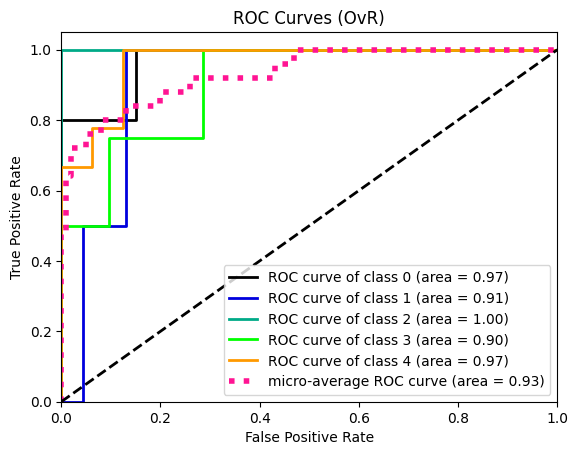

In [20]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_rf, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


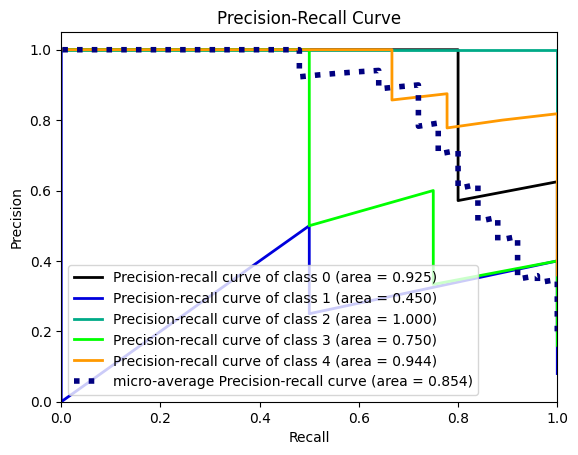

In [21]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_rf)
plt.show()

### XGBoost

In [22]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob') # XGBClassifier for multi-class classification

In [23]:
xgb_model_params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.5),
    "max_depth": randint(2, 6), 
    "n_estimators": randint(50, 150),
}

param_combinations_xgb = 50

In [24]:
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=xgb_model_params, n_iter=param_combinations_xgb, scoring=score_metric, n_jobs=-1, 
                                       cv=stratified_shufflesplit.split(X_train, Y_train), return_train_score=True, refit=True, verbose=6, random_state=RANDOM_STATE)

In [25]:
random_search_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=<generator object BaseShuffleSplit.split at 0x0000023ACB421140>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023ACB3E36B0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023ACB255CD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023ACB254710>},
                   random_state=42, return_train_score=True,
                   scoring='roc_auc_ovo', verbose=6)

In [26]:
random_search_xgb_results = pd.DataFrame(random_search_xgb.cv_results_)
random_search_xgb_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.280815,0.023701,0.060632,0.018159,0.187270,0.485357,4,121,"{'gamma': 0.18727005942368125, 'learning_rate'...",0.876866,...,0.868015,0.022873,13,0.997085,0.997156,0.996124,0.997776,0.996331,0.996894,0.000599
1,0.361365,0.090515,0.058609,0.013401,0.299329,0.088009,4,136,"{'gamma': 0.2993292420985183, 'learning_rate':...",0.870374,...,0.861410,0.014204,37,0.994160,0.994972,0.993243,0.994370,0.993270,0.994003,0.000665
2,0.240074,0.030535,0.064024,0.028309,0.029042,0.443088,5,73,"{'gamma': 0.02904180608409973, 'learning_rate'...",0.883315,...,0.870433,0.015466,6,0.999772,0.999777,0.999836,0.999726,0.999711,0.999765,0.000044
3,0.528497,0.040661,0.067637,0.018582,0.325444,0.038206,5,79,"{'gamma': 0.32544423647442644, 'learning_rate'...",0.867952,...,0.859385,0.011667,44,0.993503,0.995907,0.993344,0.992912,0.994335,0.994000,0.001059
4,0.205317,0.011411,0.059024,0.017145,0.106170,0.100912,2,82,"{'gamma': 0.10616955533913808, 'learning_rate'...",0.902694,...,0.871147,0.023624,5,0.957285,0.957420,0.962960,0.956862,0.956547,0.958215,0.002392


In [27]:
report_best_score(random_search_xgb)

Best Score: 0.87
Best Params: {'gamma': 0.4537832369630465, 'learning_rate': 0.13464611457443748, 'max_depth': 2, 'n_estimators': 64}


In [28]:
best_xgb_model = random_search_xgb.best_estimator_

#### Results on Test Split

In [29]:
Y_test_predicted_proba_xgb = best_xgb_model.predict_proba(X_test)
len(Y_test_predicted_proba_xgb), Y_test_predicted_proba_xgb[:2]

(25,
 array([[0.02186056, 0.02413998, 0.06066518, 0.24251282, 0.65082145],
        [0.00544387, 0.00529221, 0.01434298, 0.19332172, 0.7815992 ]],
       dtype=float32))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


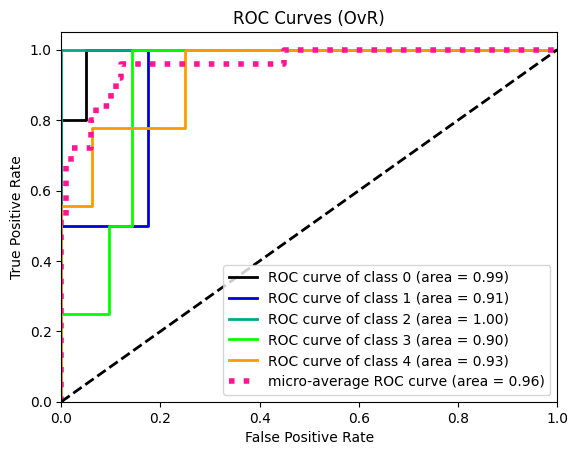

In [30]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_xgb, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


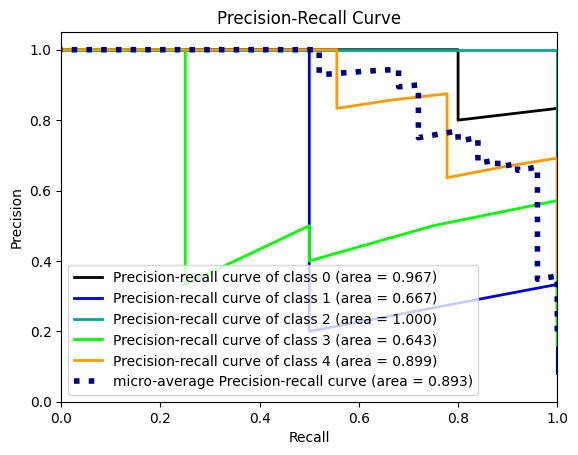

In [31]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_xgb)
plt.show()

#### Feature Importance

In [32]:
for index, feature in enumerate(df.columns):
    print(f"f{index}: {feature}")

f0: EnvironmentalAwareness
f1: CommunityInvolvement
f2: MonthlyElectricityConsumption
f3: MonthlyWaterConsumption
f4: PhysicalActivities
f5: DietType_Balanced
f6: DietType_Mostly Animal-Based
f7: DietType_Mostly Plant-Based
f8: TransportationMode_Bike
f9: TransportationMode_Car
f10: TransportationMode_Public Transit
f11: TransportationMode_Walk


<Axes: title={'center': 'Feature importance (weight)'}, xlabel='Score', ylabel='Features'>

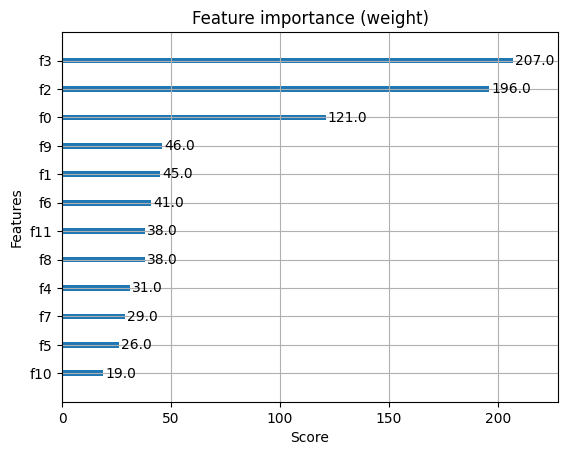

In [33]:
xgb.plot_importance(best_xgb_model, importance_type="weight", title="Feature importance (weight)", xlabel="Score")

<Axes: title={'center': 'Feature importance (gain)'}, xlabel='Score', ylabel='Features'>

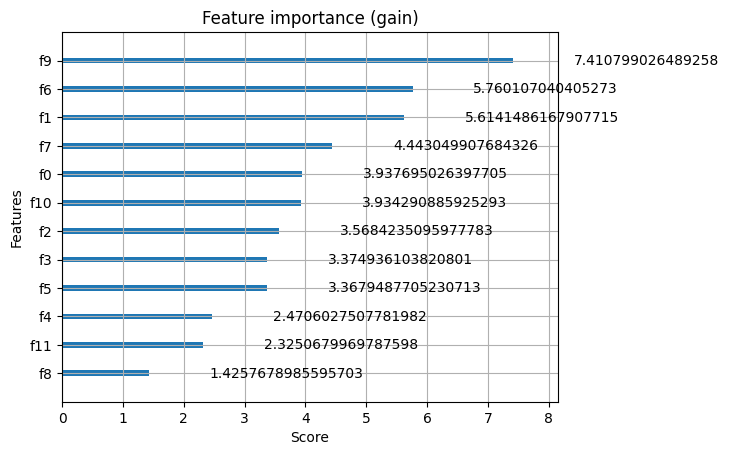

In [34]:
xgb.plot_importance(best_xgb_model, importance_type="gain", title="Feature importance (gain)", xlabel="Score")